In [1]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import argrelextrema

api_secret = 'vRrs2d0ykMDTbueG6ld06gL8eiXqJnHqRWwpZ5xb5UfGO8tt6bLs3OaYGXgmArYu'
api_key = 'mH4dfyAtk73b9ExEl4ggSVhDScBU4F9ucAdohY2GgFiZz2GWqhXTZMfYkis0LfV4'
client = Client(api_key, api_secret)


Bad key "text.kerning_factor" on line 4 in
C:\Users\Travail\anaconda3\envs\Robot\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [69]:
symbol = 'RSRUSDT'
time = '1 day ago utc'
klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_5MINUTE,time)
df = pd.DataFrame(klines, columns=['date', 'open', 'high','low','close','None', 'None', 'None','None','None','None','None'])
df = df.drop('None', axis=1)
df.set_index('date', inplace = True)
df.index = pd.to_datetime(df.index, unit='ms')
df['ind'] = [x for x in range(0, len(df['close'].values))]
df['open'], df['high'] = pd.to_numeric(df['open'], errors ='coerce'), pd.to_numeric(df['high'], errors ='coerce')
df['low'], df['close'] = pd.to_numeric(df['low'], errors ='coerce'), pd.to_numeric(df['close'], errors ='coerce')

In [70]:
def ressistance(data,n): 
    
    data['ind'] = [x for x in range(0, len(data['close'].values))]
    
    close = data.close.values
    high = data.high.values

    extrema_max_close = list(argrelextrema(close,np.greater,order=n)[0])
    extrema_max_high = list(argrelextrema(high,np.greater,order=n)[0])

    price_close = list(close[extrema_max_close])

    price_high = list(high[extrema_max_high])

    price_max = price_close+price_high

    index_max = extrema_max_close+extrema_max_high

    data_max = pd.DataFrame({'index':index_max,'price':price_max})
    data_max = data_max.sort_values('index')
    data_max.index = [x for x in range(0, len(data_max.values))]

    combinaison = list(combinations(data_max.index,3))

    nb=0
    liste_plot_r = []
    liste_plot_r_start = []

    for element in combinaison:
        lst_index = data_max['index'][element[0]], data_max['index'][element[1]], data_max['index'][element[2]]
        lst_price = data_max['price'][element[0]], data_max['price'][element[1]], data_max['price'][element[2]]

        if len(set(lst_index)) == 3:
            if np.corrcoef(lst_index,lst_price)[0][1] >= 0.999 or np.corrcoef(lst_index,lst_price)[0][1] <= -0.999:

                variancex = pd.DataFrame(lst_index).var()[0]
                variancey = pd.DataFrame(lst_price).var()[0]

                cov = np.cov(lst_index,lst_price)[0][1]

                a=(cov)/variancex
                b = np.mean(lst_price) - (a*(np.mean(lst_index)))

                témoin = a * data['ind'][np.min(lst_index):np.max(lst_index)+1] + b

                if all(data['close'][np.min(lst_index):np.max(lst_index)+1] < (témoin*1.001)):

                    lst_price_new = list(lst_price)
                    lst_index_new = list(lst_index)

                    potential_close_price = list(data['close'][np.max(lst_index_new)+n:].values)
                    potential_close_index = list(data['ind'][np.max(lst_index_new)+n:].values)
                    potential_high_price = list(data['close'][np.max(lst_index_new)+n:].values)
                    potential_high_index = list(data['ind'][np.max(lst_index_new)+n:].values)

                    potential_price = potential_close_price + potential_high_price
                    potential_index = potential_close_index + potential_high_index

                    potential  = pd.DataFrame({'potential_index':potential_index,'potential_price':potential_price})
                    potential = potential.sort_values('potential_index')
                    potential.index = [x for x in range(0, len(potential.values))]

                    for i in range(0,len(potential)):

                        potental_point_ind = lst_index_new.copy()
                        potental_point_pri = lst_price_new.copy()
                        potental_point_ind.append(potential['potential_index'][i])
                        potental_point_pri.append(potential['potential_price'][i])
                        if np.corrcoef(potental_point_ind,potental_point_pri)[0][1] > 0.9999 or np.corrcoef(potental_point_ind,potental_point_pri)[0][1] < -0.9999:
                            data.loc[data.index[int(np.max(potental_point_ind)-1):],'r'+str(nb)] = a*data['ind']+b
                            data.loc[data.index[int(np.min(potental_point_ind)):int(np.max(potental_point_ind))],'r_start'+str(nb)] = a*data['ind']+b

                            data.loc[data.index[int(np.max(potental_point_ind))],'point_r'] = potental_point_pri[-1]

                            liste_plot_r.append('r'+str(nb))
                            liste_plot_r_start.append('r_start'+str(nb))
                            nb+=1
                            break
    
    try:
        ressistance_plot = data[liste_plot_r]
        ressistance_start_plot = data[liste_plot_r_start]
        point_ressistance = data['point_r']
        if point_ressistance[-1] > 0:
            as_value_r = 1
        else:
            as_value_r = None
    except:
        ressistance_plot,ressistance_start_plot,point_ressistance,as_value_r = None , None , None,None
        pass

    return(ressistance_plot,ressistance_start_plot,point_ressistance,as_value_r)

In [71]:
def support(data,n): 
    
    data['ind'] = [x for x in range(0, len(data['close'].values))]
    
    close = data.close.values
    low = data.low.values

    extrema_min_close = list(argrelextrema(close,np.less,order=n)[0])
    extrema_min_low = list(argrelextrema(low,np.less,order=n)[0])

    price_close = list(close[extrema_min_close])

    price_low = list(low[extrema_min_low])

    price_min = price_close+price_low

    index_min = extrema_min_close+extrema_min_low

    data_min = pd.DataFrame({'index':index_min,'price':price_min})
    data_min = data_min.sort_values('index')
    data_min.index = [x for x in range(0, len(data_min.values))]

    combinaison = list(combinations(data_min.index,3))

    nb=0
    liste_plot_s = []
    liste_plot_s_start = []

    for element in combinaison:
        lst_index = data_min['index'][element[0]], data_min['index'][element[1]], data_min['index'][element[2]]
        lst_price = data_min['price'][element[0]], data_min['price'][element[1]], data_min['price'][element[2]]

        if len(set(lst_index)) == 3:
            if np.corrcoef(lst_index,lst_price)[0][1] >= 0.999 or np.corrcoef(lst_index,lst_price)[0][1] <= -0.999:

                variancex = pd.DataFrame(lst_index).var()[0]
                variancey = pd.DataFrame(lst_price).var()[0]

                cov = np.cov(lst_index,lst_price)[0][1]

                a=(cov)/variancex
                b = np.mean(lst_price) - (a*(np.mean(lst_index)))

                témoin = a * data['ind'][np.min(lst_index):np.max(lst_index)+1] + b

                if all(data['close'][np.min(lst_index):np.max(lst_index)+1] > (témoin*0.999)):

                    lst_price_new = list(lst_price)
                    lst_index_new = list(lst_index)

                    potential_close_price = list(data['close'][np.max(lst_index_new)+n:].values)
                    potential_close_index = list(data['ind'][np.max(lst_index_new)+n:].values)
                    potential_low_price = list(data['close'][np.max(lst_index_new)+n:].values)
                    potential_low_index = list(data['ind'][np.max(lst_index_new)+n:].values)

                    potential_price = potential_close_price + potential_low_price
                    potential_index = potential_close_index + potential_low_index

                    potential  = pd.DataFrame({'potential_index':potential_index,'potential_price':potential_price})
                    potential = potential.sort_values('potential_index')
                    potential.index = [x for x in range(0, len(potential.values))]

                    for i in range(0,len(potential)):

                        potental_point_ind = lst_index_new.copy()
                        potental_point_pri = lst_price_new.copy()
                        potental_point_ind.append(potential['potential_index'][i])
                        potental_point_pri.append(potential['potential_price'][i])
                        if np.corrcoef(potental_point_ind,potental_point_pri)[0][1] > 0.9999 or np.corrcoef(potental_point_ind,potental_point_pri)[0][1] < -0.9999:
                            data.loc[data.index[int(np.max(potental_point_ind)-1):],'s'+str(nb)] = a*data['ind']+b
                            data.loc[data.index[int(np.min(potental_point_ind)):int(np.max(potental_point_ind))],'s_start'+str(nb)] = a*data['ind']+b

                            data.loc[data.index[int(np.max(potental_point_ind))],'point_s'] = potental_point_pri[-1]

                            liste_plot_s.append('s'+str(nb))
                            liste_plot_s_start.append('s_start'+str(nb))
                            nb+=1
                            break
    

    try:
        support_plot = data[liste_plot_s]
        support_start_plot = data[liste_plot_s_start]
        point_support = data['point_s']
        if point_support[-1] > 0:
            as_value_s = 1
        else:
            as_value_s = None
    except:
        support_plot,support_start_plot,point_support,as_value_s = None, None, None,None
        pass
    
    return(support_plot,support_start_plot,point_support,as_value_s)

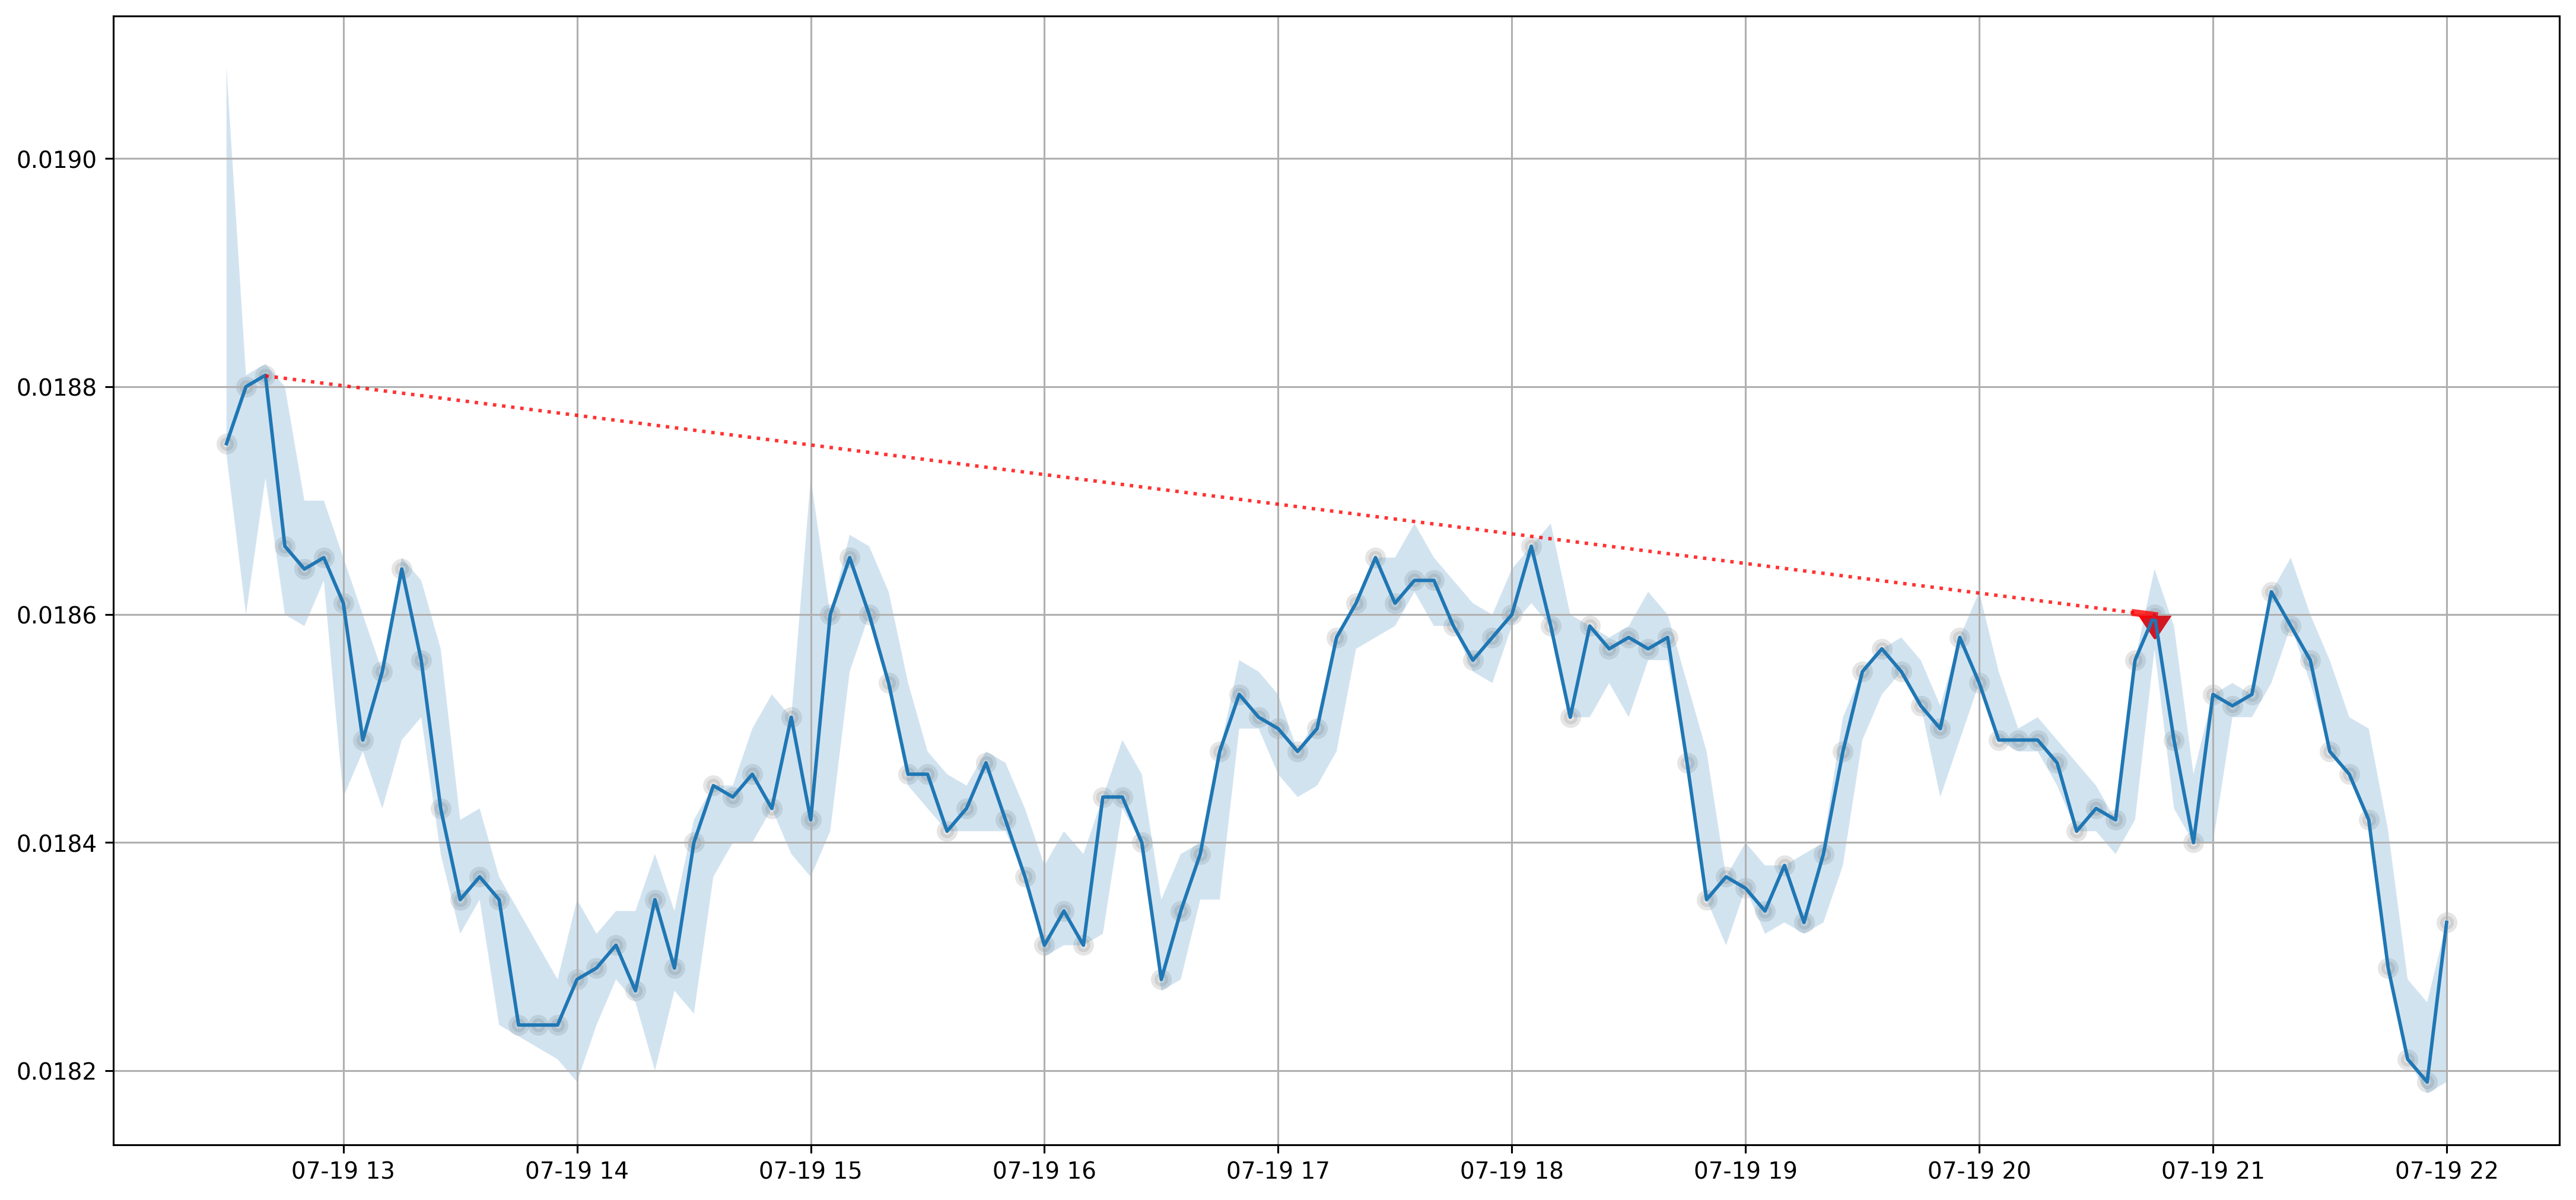

In [72]:
i = 100
n = 5
for i in range(100,len(df.close)):
    data = df[i-100:i]
    ressistance_plot,ressistance_start_plot,point_ressistance,as_value_r = ressistance(data,n)
    support_plot,support_start_plot,point_support,as_value_s = support(data,n)
    
    if as_value_s == 1 or as_value_r == 1:
    
        plt.figure(figsize=(19,9),dpi=280)
        plt.plot(df[i-100:i+28].index,df[i-100:i+28].close)
        plt.scatter(df[i-100:i+28].index,df[i-100:i+28].close,alpha=0.2,lw=3,c='gray')
        
        try:
            plt.plot(data.index,ressistance_plot,c='red',alpha=0.8,lw=3)
            plt.plot(data.index,ressistance_start_plot,c='red',alpha=0.8,ls=':')
            plt.scatter(data.index,point_ressistance,c='red',marker=11,s=172)
        except:
            pass

        try:
            plt.plot(data.index,support_plot,c='green',alpha=0.8,lw=3)
            plt.plot(data.index,support_start_plot,c='green',alpha=0.8,ls=':')
            plt.scatter(data.index,point_support,c='green',marker=10,s=172)
        except:
            pass

        plt.fill_between(df[i-100:i+28].index, df[i-100:i+28].high, df[i-100:i+28].low, alpha=0.2)
        plt.grid()
        plt.show()